In [9]:
!python -m venv myenv

!source myenv/bin/activate

In [13]:
!pip install seal
!pip install python-dp

DEPRECATION: Loading egg at /home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/seal-4.0.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/jun/.pyenv/versions/3.11.8/lib/python3.11/site-packages/seal-4.0.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [1]:
# 必要なライブラリのインポート
import pandas as pd
from seal import EncryptionParameters, SEALContext, KeyGenerator, Encryptor, BatchEncoder, Plaintext, Ciphertext, scheme_type, CoeffModulus, Decryptor, Evaluator, PlainModulus
import numpy as np
import random
from pydp.algorithms.laplacian import BoundedMean
import matplotlib.pyplot as plt


In [3]:
# データセットの読み込み
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
data = pd.read_csv(url, names=columns, na_values=" ?", skipinitialspace=True)

# 年齢データの抽出
ages = data['age'].dropna().tolist()

In [4]:

# 暗号化パラメータの設定
parms = EncryptionParameters(scheme_type.bfv)
poly_modulus_degree = 8192
parms.set_poly_modulus_degree(poly_modulus_degree)
parms.set_coeff_modulus(CoeffModulus.BFVDefault(poly_modulus_degree))
parms.set_plain_modulus(1032193)  # ここを適切な値に変更

context = SEALContext(parms)
keygen = KeyGenerator(context)
public_key = keygen.create_public_key()
secret_key = keygen.secret_key()

encoder = BatchEncoder(context)
encryptor = Encryptor(context, public_key)

# 平均値リストの初期化
true_averages = []
private_averages = []

# サンプルサイズとイテレーション数の設定
sample_size = 1000
num_iterations = 30
# epsilonの値を大きく設定
epsilon = 10.0
lower_bound = min(ages)
upper_bound = max(ages)

In [5]:
for _ in range(num_iterations):  # 30回サンプリングして評価
    ages_sample = random.sample(ages, sample_size)

    # 年齢データの暗号化
    encrypted_ages = []
    for age in ages_sample:
        age_array = np.array([age], dtype=np.int64)
        plain = encoder.encode(age_array)
        encrypted = encryptor.encrypt(plain)
        encrypted_ages.append(encrypted)

    # クラウドサーバーでの暗号化されたデータの処理
    evaluator = Evaluator(context)
    encrypted_sum = evaluator.add_many(encrypted_ages)

    # 復号と差分プライバシの適用
    decryptor = Decryptor(context, secret_key)
    plain_result = decryptor.decrypt(encrypted_sum)
    decoded_result = np.array(encoder.decode(plain_result), dtype=np.int64)
    sum_result = sum(decoded_result)
    average_age = sum_result / sample_size

    # 差分プライバシの適用
    dp_mean = BoundedMean(epsilon=epsilon, lower_bound=lower_bound, upper_bound=upper_bound, dtype='float')
    dp_mean.add_entry(average_age)
    private_average_age = dp_mean.result()

    # 結果をリストに追加
    true_averages.append(average_age)
    private_averages.append(private_average_age)

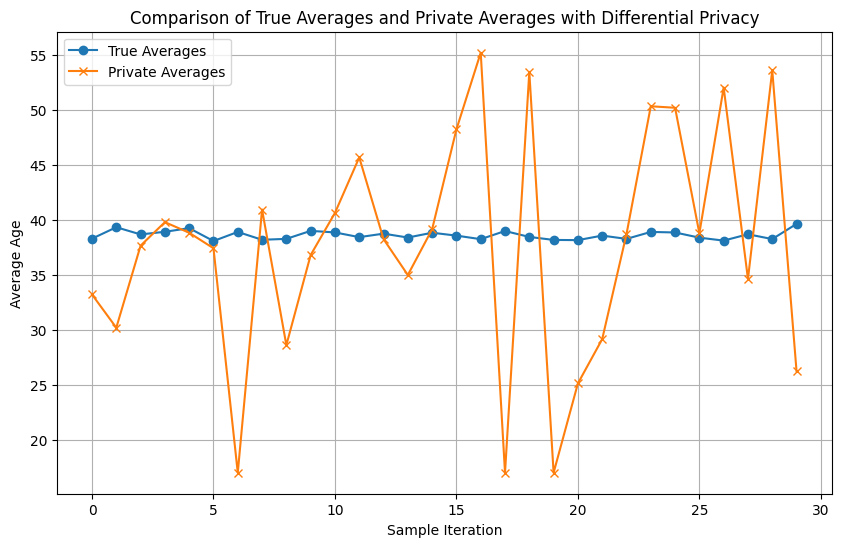

In [6]:
# グラフの描画
plt.figure(figsize=(10, 6))
plt.plot(true_averages, label='True Averages', marker='o')
plt.plot(private_averages, label='Private Averages', marker='x')
plt.xlabel('Sample Iteration')
plt.ylabel('Average Age')
plt.legend()
plt.title('Comparison of True Averages and Private Averages with Differential Privacy')
plt.grid(True)
plt.show()

Private average age: 120.0


NameError: name 'true_averages' is not defined

<Figure size 1000x600 with 0 Axes>